In [1]:
import os
import numpy as np
import datetime
from tensorflow_core.python.keras.callbacks import EarlyStopping
from tensorflow_core.python.keras.utils import np_utils
from tensorflow_core.python.keras.models import Sequential
from tensorflow_core.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.python import math_ops
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow_core.python.keras.layers import Activation
from tensorflow_core.python.keras.utils import get_custom_objects   # 自定義gelu

np.random.seed(10)

In [2]:

# sentence_type = 'SA1'
# sentence_type = 'SA2'
# sentence_type = 'SA'
sentence_type = 'SX'

Tr_ver = 'pe_50_M_'
Te_ver = 'pe_50_M_'

Tr_ver += sentence_type + '_'
Te_ver += sentence_type + '_'

Tr_ver += '2_'
Te_ver += '2_'

shape = 50

now_path = r'D:\TIMITDIC_231101'
data_path = now_path + '_data_Italian_Spanish'

Tr_CDF_path = os.path.join(data_path, 'TRAIN', 'cnn_dataset_librosa')
Te_CDF_path = os.path.join(data_path, 'TEST', 'cnn_dataset_librosa')

Tr_DS_path = os.path.join(Tr_CDF_path, 'mfcc', Tr_ver + 'SoundDataset.npz')

Te_DS_path = os.path.join(Te_CDF_path, 'mfcc', Te_ver + 'SoundDataset.npz')

In [3]:
Tr_DS = np.load(Tr_DS_path)
Te_DS = np.load(Te_DS_path)

train_value, train_label = Tr_DS['TrainValue'], Tr_DS['TrainLabel_class']
test_value, test_label = Te_DS['TestValue'], Te_DS['TestLabel_class']
# test_value, test_label, test_label2 = Te_DS['TestValue'], Te_DS['TestLabel_class'], Te_DS['TestLabel_type']

train_value_4D = train_value.reshape(train_value.shape[0], shape, shape, 1).astype('float32')
test_value_4D = test_value.reshape(test_value.shape[0], shape, shape, 1).astype('float32')

# 向量轉換為二進制(只有0和1)的矩陣類型
# 但train_label、test_label原先資料就都是0跟1?
train_label_OneHot = np_utils.to_categorical(train_label)
test_label_OneHot = np_utils.to_categorical(test_label)

In [4]:
class Davis( Activation ):    
    def __init__(self, activation, **kwargs):
        super(Davis, self).__init__(activation, **kwargs)
        self.__name__ = 'custom_gelu'

def custom_gelu(x):
    return 0.5 * x * (1 + math_ops.tanh(math_ops.sqrt(2 / np.pi) * (x + 0.044715 * math_ops.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Davis(custom_gelu)})
get_custom_objects().update({'Davis': (Activation)})

In [5]:
activation_cate = 'relu'
# activation_cate = 'custom_gelu'
# activation_cate = 'sigmoid'
# activation_cate = 'elu'
# activation_cate = 'tanh'
kernel_size = 3

model = Sequential()
model.add(Conv2D(32, (kernel_size, kernel_size), input_shape=(shape, shape, 1), padding='same', activation=activation_cate))
model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(Conv2D(64, (kernel_size, kernel_size), padding='same', activation=activation_cate))
# model.add(Conv2D(128, (3, 3), padding='same', activation='custom_gelu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='custom_gelu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation=activation_cate))
# model.add(Dropout(0.2))
model.add(Dense(128, activation=activation_cate))
model.add(Dropout(0.5))
# model.add(Dense(32, activation=activation_cate))
# model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
model.summary()
model.compile(loss='binary_crossentropy',  # mean_squared_error, binary_crossentropy, categorical_crossentropy
              optimizer="adam",  # sgd, rmsprop, adam
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0

In [7]:
# 創建一個早停法的回調函數
# early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
# early_stopping = EarlyStopping(monitor='val_acc', patience=100, restore_best_weights=True)

train_history=model.fit(x=train_value_4D,
                        y=train_label_OneHot,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=10,
                        verbose=2,
                        # callbacks=[early_stopping])
                        )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 303 samples, validate on 76 samples
Epoch 1/100
303/303 - 2s - loss: 0.4986 - acc: 0.7910 - val_loss: 0.5043 - val_acc: 0.7807
Epoch 2/100
303/303 - 0s - loss: 0.4940 - acc: 0.7877 - val_loss: 0.4368 - val_acc: 0.7807
Epoch 3/100
303/303 - 0s - loss: 0.3746 - acc: 0.8372 - val_loss: 0.3069 - val_acc: 0.8289
Epoch 4/100
303/303 - 0s - loss: 0.2756 - acc: 0.8735 - val_loss: 0.2507 - val_acc: 0.8728
Epoch 5/100
303/303 - 0s - loss: 0.2372 - acc: 0.8812 - val_loss: 0.2439 - val_acc: 0.8728
Epoch 6/100
303/303 - 0s - loss: 0.1938 - acc: 0.9230 - val_loss: 0.1561 - val_acc: 0.9342
Epoch 7/100
303/303 - 0s - loss: 0.1629 - acc: 0.9329 - val_loss: 0.2044 - val_acc: 0.9123
Epoch 8/100
303/303 - 0s - loss: 0.1347 - acc: 0.9406 - val_loss: 0.1410 - val_acc: 0.9342
Epoch 9/100
303/303 - 0s - loss: 0.1270 - acc: 0.9417 - val_loss: 0.1782 - val_acc: 0.9254
Epoch 10/100
303/303 - 0s - loss: 0.0956 -

{'loss': [0.49859851800372496, 0.4939597922779939, 0.3745556431069429, 0.27564201535958266, 0.23716611683171968, 0.1937986092731086, 0.1629487901030882, 0.13471206106866399, 0.12699033312265925, 0.09562437726213925, 0.11018965753171768, 0.07959355222577653, 0.08330524346673832, 0.09090464463628053, 0.07099516932424557, 0.08931441989331895, 0.06486385170886717, 0.07024198104362327, 0.03732003397805208, 0.04259002957998878, 0.04692108659653866, 0.03779235998699613, 0.04963772021294885, 0.06952960790719018, 0.05105341656235396, 0.040803426626159905, 0.04953922630125283, 0.04398313988377015, 0.019373222533728706, 0.034346836306969344, 0.015121592534484776, 0.014969599062937855, 0.017594929309612036, 0.014433734669207504, 0.03556759302504024, 0.018300255305448956, 0.07091159352030903, 0.04616469354923448, 0.02307665382521327, 0.016942682719662525, 0.014706322026799015, 0.0034057662053677325, 0.0032719166262691252, 0.014646446345976392, 0.0034071562412420595, 0.004287003587862089, 0.00368301

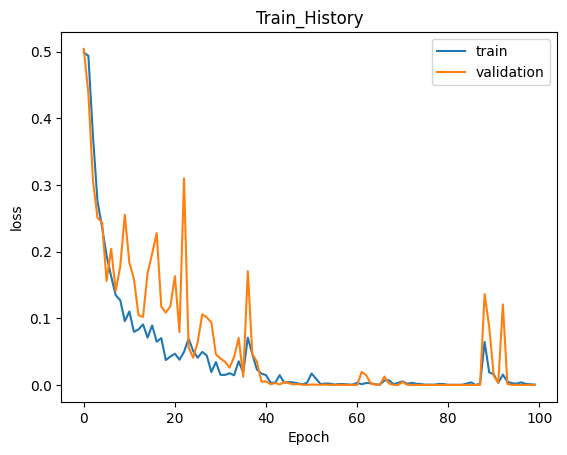

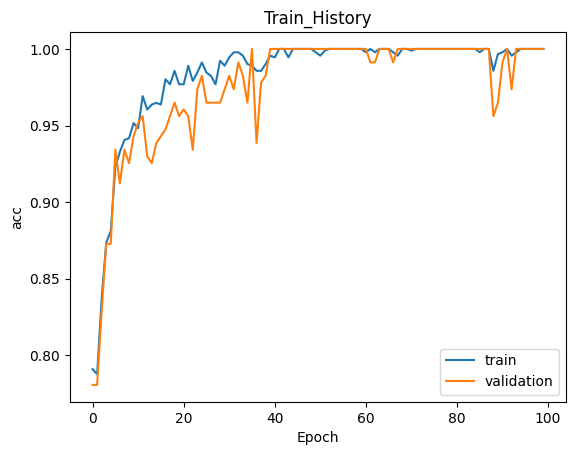

In [8]:
now_str = datetime.datetime.now()
now_str = datetime.datetime.strftime(now_str, '%Y%m%d_%H%M%S')

def show_train_history(train_history, train, validation):
    # 定義show_train_history函數，輸入下列參數:之前訓練過程所產生的train_history、
    # ...訓練資料的執行結果、驗證資料的執行結果
    print(train_history.history)
    plt.style.use('default')
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train_History')  # 顯示圖的標題
    plt.ylabel(train)  # 顯示y軸的標籤
    plt.xlabel('Epoch')  # 設定x軸標籤是'Epoch'
    plt.legend(['train', 'validation'], loc='best')
    # 設定國例是顯示'train', 'validation',位置在左上角

    train_history_path = os.path.join(now_path, 'train_history', Tr_ver)
    os.makedirs(train_history_path, exist_ok=True)

    plt.savefig(os.path.join(train_history_path, now_str + '_' + train + '.png'), bbox_inches='tight', pad_inches=0)

    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'acc', 'val_acc')
# show_train_history(train_history, 'accuracy', 'val_accuracy')

In [9]:
scores = model.evaluate(test_value_4D, test_label_OneHot)
print('loss=', scores[0], '\nacc=', scores[1])

f = open(os.path.join(now_path, 'train_history', 'train_history.txt'), 'a+')  # a+

content = f.read()
f.seek(0, 0)

f.write('\n' + '---------------------------------' + '\n')
f.write('\n' + '*****' + Tr_ver + '*****' + '\n')
f.write(now_str + '\n')
f.write('loss=' + '\n' + str(scores[0]) + '\n')
f.write('acc=' + '\n' + str(scores[1]))

f.write('\n' + content)
f.close()

117/117 [==============================] - 0s 2ms/sample - loss: 9.4369e-06 - acc: 1.0000
loss= 9.436914880121223e-06 
acc= 1.0


In [10]:
# 使用pd.crosstab建立混淆矩陣，輸入下列參數:
prediction = model.predict_classes(test_value_4D)
pd.crosstab(test_label,  # 測試資料數字影像的其實值
            prediction,  # 測試資料數字影像的預測結果
            rownames=['label'],  # 設定行的名稱是label
            colnames=['predict'])  # 設定列的名稱是predict

predict,0,1,2
label,,,
0,90,0,0
1,0,20,0
2,0,0,7


In [11]:
MWpath = os.path.join(now_path, '..\..', 'model_weight')
os.makedirs(MWpath, exist_ok=True)
Wver = now_path.split('\\')[-1]
model.save(os.path.join(MWpath, Tr_ver + 'SoundWeight_' + Wver + '_type2.h5'))